In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
print(iskaggle)
print(type(iskaggle))

if iskaggle:
    !pip install -Uqq fastai

Batch
<class 'str'>


# Building a simple model for creating a web app

### The first step in building an AI application is to create a simple model we can host on the web

In [4]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

## Let's try creating a computer vision model that can distinguish between a human brain and a computer

## First we need to get some images
Check we can get some image urls

In [5]:
urls = search_images('human brain', max_images=1)
print(urls[0])

https://www.3bscientific.com/thumblibrary/VR1615L/VR1615L_01_3200_3200_Human-Brain-Chart.jpg


Now we can look at the data

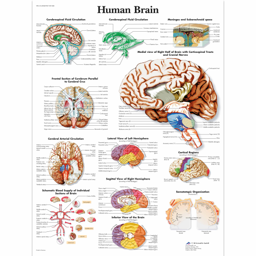

In [6]:
from fastdownload import download_url
dest = 'brain.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now we need to do the same thing with images of computers

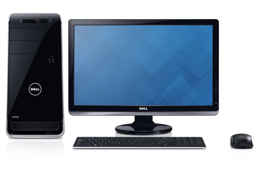

In [7]:
download_url(search_images('personal computer', max_images=1)[0], 'computer.jpeg')
Image.open('computer.jpeg').to_thumb(256,256)

Now we are getting some reasonable results we need to create some data sets. To train a model on a GPU we want all of the images to be the same size so that we can make use of the GPU's parrallel processing

In [8]:
import shutil
searches = 'human brain', 'personal computer'

path = Path('brain_or_computer')
resized_path = path/'resized_images'

try:
    shutil.rmtree(path)
except FileNotFoundError as e:
    print("folder doesn't exist yet")
    
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=resized_path/o)

folder doesn't exist yet


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Remove any images which failed to download properly

In [9]:
failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

0

Create a Datablock of images to 

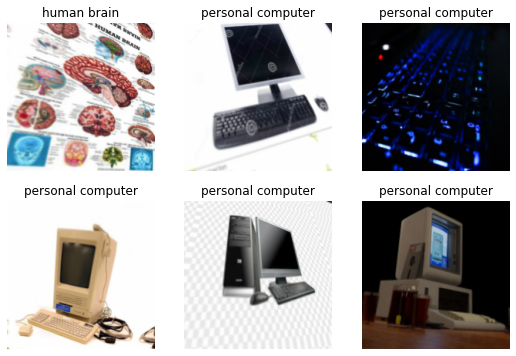

In [10]:
dls = DataBlock(
      blocks=(ImageBlock, CategoryBlock),   # we take in an image and output a category
      get_items=get_image_files,   # creates a list of all the image files in the folder
      splitter=RandomSplitter(valid_pct=0.2, seed=42),   # creates a testing and training data split
      get_y=parent_label,    # gets label of each image from the name of the parent directory
      item_tfms=[Resize(192, method='squish')],    # Resize all images so that they are the same size
      batch_tfms=aug_transforms(mult=1.5)  # transform the images slightly in RAM to extend the data set
      ).dataloaders(resized_path)   # where to get the images from

dls.show_batch(max_n=6)

Now we create a simple model

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.913373,0.128174,0.039474,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.124787,0.037689,0.013158,00:02
1,0.071955,0.008674,0.000000,00:02
2,0.054221,0.006431,0.000000,00:02


In [12]:
is_brain,_,probs = learn.predict(PILImage.create('brain.jpg'))
print(f"This is a: {is_brain}.")
print(f"Probability it's a brain: {probs[0]:.4f}")

This is a: human brain.
Probability it's a brain: 0.9992


## We use our model to clean our data
From the confusion matrix it looks like we have built a good model which can easily tell the difference between human brains and computers 

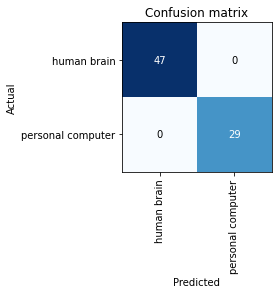

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

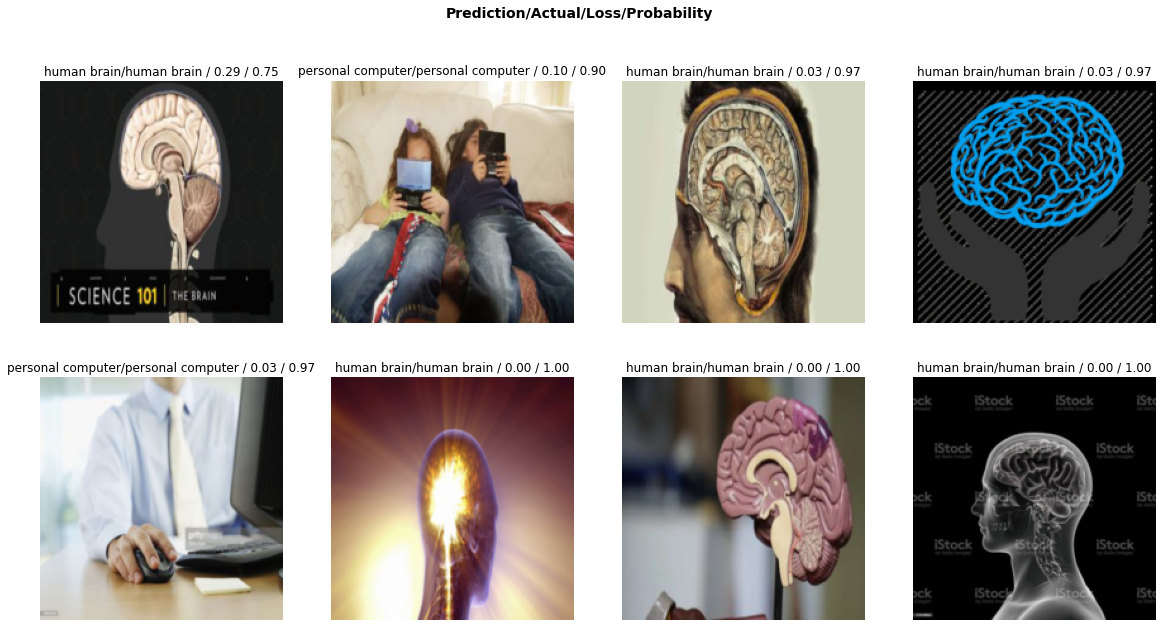

In [14]:
interp.plot_top_losses(8, nrows=2,  figsize = (20,10))
# One image is produced, figsize sets it's size. If txt is overlapping try increasing the x axis

The model seems kinda good, let's use it to clean our data

In [15]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
cleaner

### Now we just need to save our model

In [17]:
learn.export('model.pk')